# Chia lại data (Chạy 1 lần, các lần sau ko cần)

In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from collections import Counter

data_dir = "/content/wlasl_keypoints"
def truncate_or_pad(arr, target_len=50):
    if arr.shape[0] > target_len:
        return arr[:target_len]
    elif arr.shape[0] < target_len:
        pad_len = target_len - arr.shape[0]
        pad = np.zeros((pad_len, arr.shape[1]))
        return np.concatenate([arr, pad], axis=0)
    return arr

# === Đếm số lượng mỗi nhãn ===
tmp_labels = []
for f in os.listdir(data_dir):
    if f.endswith(".npy"):
        gloss = f.replace(".npy", "").split("_")[0]
        tmp_labels.append(gloss)

label_freq = Counter(tmp_labels)
valid_labels = {label for label, count in label_freq.items() if count >= 2}

# === Đọc dữ liệu đã lọc ===
X_all, y_all = [], []
label_map, label_idx = {}, 0

for f in os.listdir(data_dir):
    if not f.endswith(".npy"):
        continue
    gloss = f.replace(".npy", "").split("_")[0]
    if gloss not in valid_labels:
        continue
    arr = np.load(os.path.join(data_dir, f))
    if len(arr.shape) != 2:
        continue
    arr = truncate_or_pad(arr, 50)
    if gloss not in label_map:
        label_map[gloss] = label_idx
        label_idx += 1
    X_all.append(arr)
    y_all.append(label_map[gloss])

X_all = np.array(X_all)
y_all = np.array(y_all)

print("📦 Tổng mẫu hợp lệ:", len(X_all))
print("📚 Số lớp:", len(label_map))

# === Chia tập train / val / test
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_all, y_all, test_size=0.10, stratify=y_all, random_state=42)

val_ratio = 0.20 / 0.90
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=val_ratio,
    stratify=y_trainval, random_state=42)

# === Chuẩn hóa
mean = np.mean(X_train, axis=(0, 1), keepdims=True)
std = np.std(X_train, axis=(0, 1), keepdims=True)
X_train = (X_train - mean) / std
X_val = (X_val - mean) / std
X_test = (X_test - mean) / std

# === One-hot
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)
y_test_cat = to_categorical(y_test)

# === Lưu
np.save("X_train.npy", X_train)
np.save("X_val.npy", X_val)
np.save("X_test.npy", X_test)
np.save("y_train.npy", y_train_cat)
np.save("y_val.npy", y_val_cat)
np.save("y_test.npy", y_test_cat)
np.save("label_map.npy", label_map)

print("✅ Dữ liệu đã xử lý và lưu xong.")
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
print(f"Số lớp còn lại sau lọc: {len(label_map)}")


📦 Tổng mẫu hợp lệ: 2038
📚 Số lớp: 100
✅ Dữ liệu đã xử lý và lưu xong.
Train: (1426, 50, 1629), Val: (408, 50, 1629), Test: (204, 50, 1629)
Số lớp còn lại sau lọc: 100


In [ ]:
print("📄 Một vài file đầu:", os.listdir(data_dir)[:5])


📄 Một vài file đầu: ['walk_train_62175.npy', 'family_train_20984.npy', 'eat_train_18333.npy', 'decide_train_15042.npy', 'year_test_64209.npy']


In [ ]:
# import numpy as np
# from collections import Counter

# Counter(y_train)  # nếu là list
# # np.bincount(y_train)  # nếu là numpy array


In [ ]:
# print(y_train.shape)
# print(y_train[:5])

(4137,)
[73 44 56 64 91]


# Code bắt đầu từ đây

In [ ]:
# === Scope 1: Import & Config ===
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# GPU config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [ ]:
import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.utils.class_weight import compute_class_weight
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load data đã xử lý sẵn
X_train = np.load("X_train.npy")
y_train = np.load("y_train.npy")
X_val = np.load("X_val.npy")
y_val = np.load("y_val.npy")
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")

# Augmentation: Gaussian + Random mask
def augment_keypoints(self, x, drop_prob=0.1, mask_prob=0.1, jitter_range=2, noise_std=0.01):
        x = x.copy()
        C, T = x.shape

        # Frame dropout
        for t in range(T):
            if random.random() < drop_prob:
                x[:, t] = 0.0

        # Keypoint masking
        joints = C // 3
        for j in range(joints):
            if random.random() < mask_prob:
                x[j*3:(j+1)*3, :] = 0.0

        # Temporal jitter
        shift = random.randint(-jitter_range, jitter_range)
        if shift > 0:
            x = np.pad(x, ((0, 0), (shift, 0)), mode='constant')[:, :-shift]
        elif shift < 0:
            x = np.pad(x, ((0, 0), (0, -shift)), mode='constant')[:, -shift:]

        # Gaussian noise
        x += np.random.normal(0, noise_std, size=x.shape)

        return x
def augment_gaussian_noise(X, noise_level=0.01):
    noise = np.random.normal(0, noise_level, X.shape)
    return X + noise

def random_mask_keypoints(X, p=0.1):
    mask = np.random.rand(*X.shape) > p
    return X * mask

# Apply augmentation
X_aug = augment_gaussian_noise(X_train)
X_aug = random_mask_keypoints(X_aug)
y_aug = y_train.copy()

# Gộp lại
X_train = np.concatenate([X_train, X_aug], axis=0)
y_train = np.concatenate([y_train, y_aug], axis=0)

# One-hot → label index
y_train = np.argmax(y_train, axis=1)
y_val = np.argmax(y_val, axis=1)
y_test = np.argmax(y_test, axis=1)

# Tensor + permute (B, C, T)
X_train = torch.tensor(X_train, dtype=torch.float32).permute(0, 2, 1)
X_val = torch.tensor(X_val, dtype=torch.float32).permute(0, 2, 1)
X_test = torch.tensor(X_test, dtype=torch.float32).permute(0, 2, 1)
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# DataLoader
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=32)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=32)

num_classes = len(torch.unique(y_train))


In [ ]:
from torch.utils.data import Dataset

class PoseDataset(Dataset):
    def __init__(self, X, y, augment=False):
        self.X = X
        self.y = y
        self.augment = augment

    def __getitem__(self, idx):
        x = self.X[idx]  # shape: (C, T)
        y = self.y[idx]
        if self.augment:
            x = augment_keypoints(x)  # chứa jitter + noise + mask

        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)



In [ ]:
num_classes = len(np.unique(y_train.cpu().numpy()))
print("Số lượng lớp (num_classes):", num_classes)


Số lượng lớp (num_classes): 100


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TemporalAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.attn = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Conv1d(in_channels, in_channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return x * self.attn(x)

class SpatialAttention(nn.Module):
    def __init__(self, in_channels):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, in_channels // 8, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels // 8, in_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x shape: (N, C, T)
        attn = self.conv1(x)
        attn = F.relu(attn)
        attn = self.conv2(attn)
        attn = self.sigmoid(attn)
        return x * attn

class ChannelSE(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super().__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Conv1d(in_channels, in_channels // reduction, 1),
            nn.ReLU(),
            nn.Conv1d(in_channels // reduction, in_channels, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return x * self.se(x)


class STGCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, dilation_list=[1, 2, 4]):
        super().__init__()
        self.gcn = nn.Conv1d(in_channels, out_channels, kernel_size=1)

        # Multi-branch TCN with different dilations
        self.tcn_branches = nn.ModuleList([
            nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=d, dilation=d, stride=stride)
            for d in dilation_list
        ])

        self.bn = nn.BatchNorm1d(out_channels)
        self.dropout = nn.Dropout(0.5)
        self.ta = TemporalAttention(out_channels)
        self.sa = SpatialAttention(out_channels)
        self.se = ChannelSE(out_channels)

        self.residual = nn.Sequential()
        if in_channels != out_channels or stride != 1:
            self.residual = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        res = self.residual(x)
        x = self.gcn(x)

        # Combine outputs from different TCN branches
        x = sum(branch(x) for branch in self.tcn_branches) / len(self.tcn_branches)

        x = self.bn(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.ta(x)
        x = self.sa(x)
        x = self.se(x)
        x = x + res
        return F.relu(x)


In [ ]:
class STGCN(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.data_bn = nn.BatchNorm1d(in_channels)

        self.layer1 = STGCNBlock(in_channels, 24)
        # self.drop1 = nn.Dropout(0.3)

        self.layer2 = STGCNBlock(24, 48)
        # self.drop2 = nn.Dropout(0.3)

        # self.layer3 = STGCNBlock(48, 96)
        # self.drop3 = nn.Dropout(0.4)

        # self.layer4 = STGCNBlock(96, 128)
        # self.drop4 = nn.Dropout(0.5)

        self.pool = nn.AdaptiveAvgPool1d(1)
        # self.drop_fc = nn.Dropout(0.5)

        self.fc = nn.Linear(48, num_classes)

    def forward(self, x):
        x = self.data_bn(x)
        x = self.layer1(x)
        x = self.layer2(x)
        # x = self.drop3(self.layer3(x))
        # x = self.drop4(self.layer4(x))
        x = self.pool(x).squeeze(-1)
        # x = self.drop_fc(x)
        return self.fc(x)


In [ ]:
def evaluate_topk(model, loader, k_values=[1, 5]):
    model.eval()
    all_outputs, all_labels = [], []

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            all_outputs.append(outputs.cpu())
            all_labels.append(y_batch)

    all_outputs = torch.cat(all_outputs)
    all_labels = torch.cat(all_labels)

    results = {}
    for k in k_values:
        acc = topk_accuracy(all_outputs, all_labels, k=k)
        results[f"top{k}"] = acc
    return results


In [ ]:
class EarlyStopping:
    def __init__(self, patience=10, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


In [ ]:
model = STGCN(in_channels=1629,num_classes=num_classes).to(device)


In [ ]:
from torchsummary import summary
summary(model, input_size=(1629, 50))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm1d-1             [-1, 1629, 50]           3,258
            Conv1d-2               [-1, 24, 50]          39,120
       BatchNorm1d-3               [-1, 24, 50]              48
            Conv1d-4               [-1, 24, 50]          39,120
            Conv1d-5               [-1, 24, 50]           1,752
            Conv1d-6               [-1, 24, 50]           1,752
            Conv1d-7               [-1, 24, 50]           1,752
       BatchNorm1d-8               [-1, 24, 50]              48
           Dropout-9               [-1, 24, 50]               0
AdaptiveAvgPool1d-10                [-1, 24, 1]               0
           Conv1d-11                [-1, 24, 1]             600
          Sigmoid-12                [-1, 24, 1]               0
TemporalAttention-13               [-1, 24, 50]               0
           Conv1d-14                [-1

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# === Tính class weight
y_train_np = y_train.cpu().numpy()
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_np), y=y_train_np)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# === Loss + Optim + Scheduler
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)
model = STGCN(in_channels=X_train.shape[1], num_classes=num_classes).to(device)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-3,
    weight_decay=5e-4
)

# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

# Logging
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(200):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pred = outputs.argmax(dim=1)
        correct += (pred == y_batch).sum().item()
        total += y_batch.size(0)

    train_loss = total_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item()
            pred = outputs.argmax(dim=1)
            correct += (pred == y_batch).sum().item()
            total += y_batch.size(0)

    val_loss = total_loss / len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1:02d} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | "
          f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    scheduler.step()


Epoch 01 | Train Acc: 0.0137 | Val Acc: 0.0123 | Train Loss: 4.6091 | Val Loss: 4.5697
Epoch 02 | Train Acc: 0.0403 | Val Acc: 0.0417 | Train Loss: 4.4523 | Val Loss: 4.3942
Epoch 03 | Train Acc: 0.0635 | Val Acc: 0.0539 | Train Loss: 4.2890 | Val Loss: 4.2435
Epoch 04 | Train Acc: 0.0877 | Val Acc: 0.0735 | Train Loss: 4.1246 | Val Loss: 4.1408
Epoch 05 | Train Acc: 0.1020 | Val Acc: 0.0858 | Train Loss: 3.9559 | Val Loss: 4.0029
Epoch 06 | Train Acc: 0.1459 | Val Acc: 0.1029 | Train Loss: 3.7844 | Val Loss: 3.8776
Epoch 07 | Train Acc: 0.1855 | Val Acc: 0.1201 | Train Loss: 3.6225 | Val Loss: 3.7947
Epoch 08 | Train Acc: 0.2142 | Val Acc: 0.1471 | Train Loss: 3.4821 | Val Loss: 3.6930
Epoch 09 | Train Acc: 0.2731 | Val Acc: 0.1936 | Train Loss: 3.3080 | Val Loss: 3.5448
Epoch 10 | Train Acc: 0.3142 | Val Acc: 0.2083 | Train Loss: 3.1798 | Val Loss: 3.4528
Epoch 11 | Train Acc: 0.3384 | Val Acc: 0.2304 | Train Loss: 3.0612 | Val Loss: 3.3843
Epoch 12 | Train Acc: 0.3745 | Val Acc: 0.2

KeyboardInterrupt: 

In [ ]:
print(X_train.shape)  # hoặc
print(X_batch.shape)


torch.Size([8274, 1629, 50])
torch.Size([31, 1629, 50])


In [ ]:
from sklearn.metrics import top_k_accuracy_score

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)

        all_preds.append(outputs.cpu())
        all_labels.append(y_batch.cpu())

# Gộp tất cả lại
all_preds = torch.cat(all_preds, dim=0).numpy()
all_labels = torch.cat(all_labels, dim=0).numpy()

# Tính top-k
top1 = top_k_accuracy_score(all_labels, all_preds, k=1)
top3 = top_k_accuracy_score(all_labels, all_preds, k=3)
top5 = top_k_accuracy_score(all_labels, all_preds, k=5)

print(f"Top-1 Accuracy: {top1:.4f}")
print(f"Top-3 Accuracy: {top3:.4f}")
print(f"Top-5 Accuracy: {top5:.4f}")


Top-1 Accuracy: 0.5564
Top-3 Accuracy: 0.7770
Top-5 Accuracy: 0.8358


In [ ]:
import matplotlib.pyplot as plt

def plot_train_val_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(14, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Train Acc")
    plt.plot(epochs, val_accuracies, label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, dataloader, class_names):
    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(xticks_rotation='vertical', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()


In [ ]:
import numpy as np

def plot_accuracy_per_class(model, dataloader, class_names):
    correct = np.zeros(len(class_names))
    total = np.zeros(len(class_names))

    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            preds = outputs.argmax(dim=1)
            for i in range(len(class_names)):
                correct[i] += ((preds == y_batch) & (y_batch == i)).sum().item()
                total[i] += (y_batch == i).sum().item()

    acc_per_class = correct / total
    plt.figure(figsize=(12, 5))
    plt.bar(class_names, acc_per_class)
    plt.xticks(rotation=90)
    plt.ylabel("Accuracy")
    plt.title("Per-Class Accuracy")
    plt.tight_layout()
    plt.show()


In [ ]:
import numpy as np
label_map = np.load("label_map.npy", allow_pickle=True).item()
idx_to_label = {v: k for k, v in label_map.items()}
class_names = [idx_to_label[i] for i in range(len(idx_to_label))]


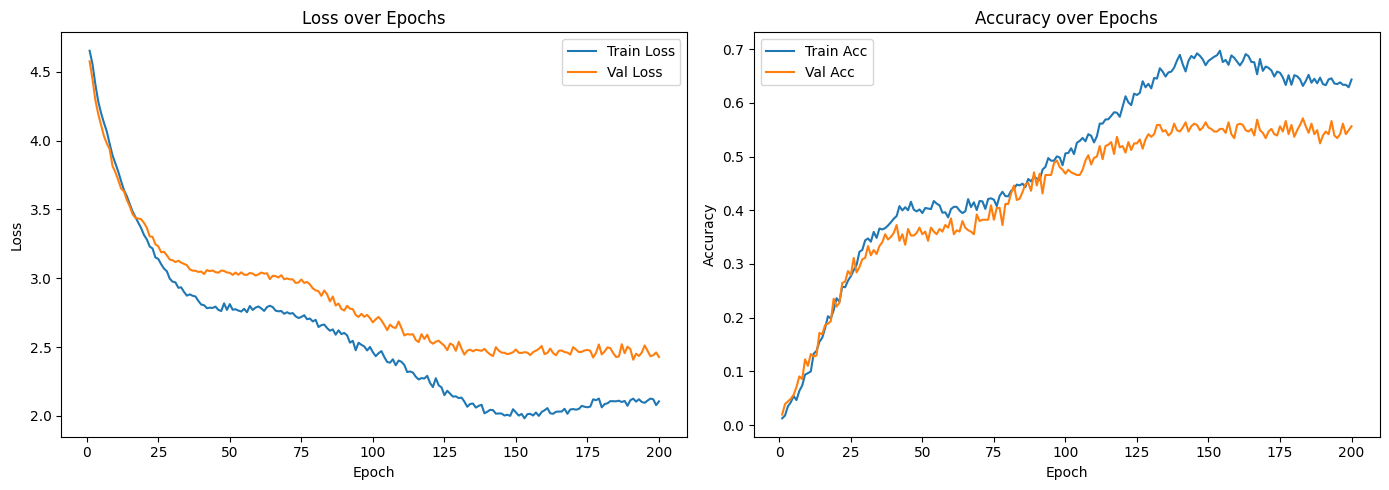

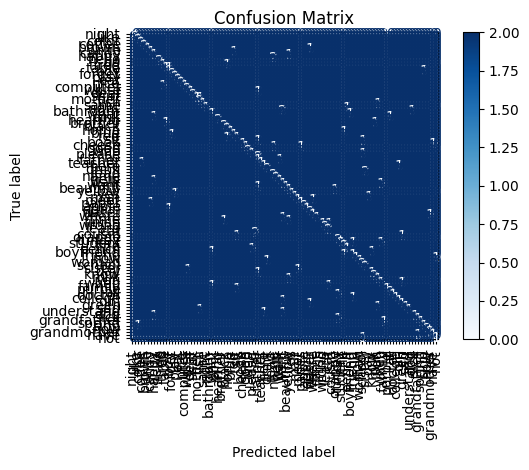

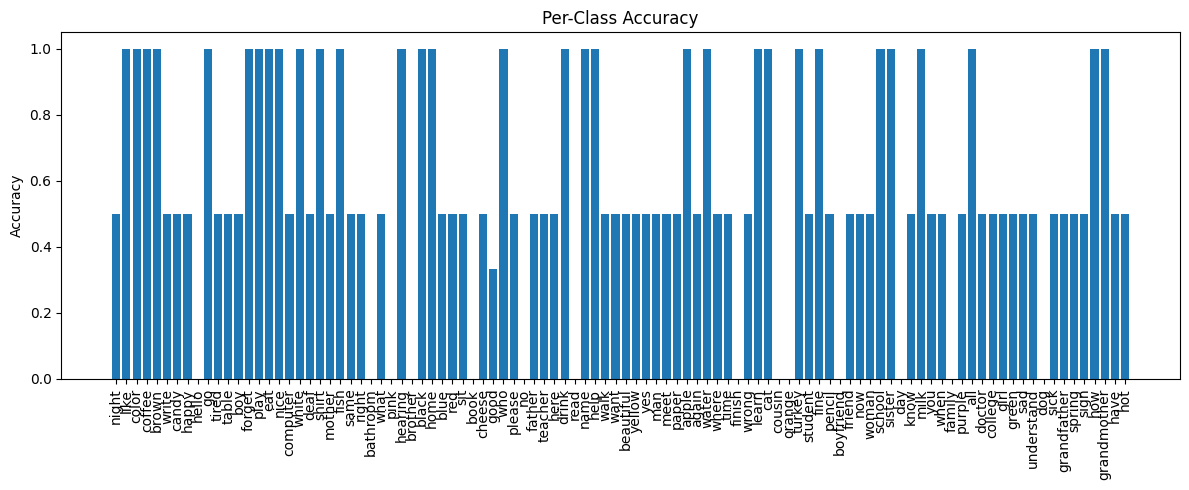

In [ ]:
plot_train_val_curves(train_losses, val_losses, train_accuracies, val_accuracies)

# Giả sử bạn có danh sách class_names:
# class_names = ['hello', 'thanks', 'apple', ...]
plot_confusion_matrix(model, test_loader, class_names)
plot_accuracy_per_class(model, test_loader, class_names)


In [ ]:
def get_top_bottom_classes(model, dataloader, class_names, device):
    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    per_class_acc = np.diag(cm) / cm.sum(axis=1)
    per_class_acc = np.nan_to_num(per_class_acc)

    top10_idx = np.argsort(per_class_acc)[-10:][::-1]
    bottom5_idx = np.argsort(per_class_acc)[:5]

    return top10_idx, bottom5_idx, cm


def plot_confusion_subset(cm, indices, class_names, title="Confusion Matrix"):
    import matplotlib.pyplot as plt
    from sklearn.metrics import ConfusionMatrixDisplay

    cm_subset = cm[np.ix_(indices, indices)]
    labels = [class_names[i] for i in indices]

    disp = ConfusionMatrixDisplay(confusion_matrix=cm_subset, display_labels=labels)
    disp.plot(xticks_rotation='vertical', cmap='Blues')
    plt.title(title)
    plt.tight_layout()
    plt.show()


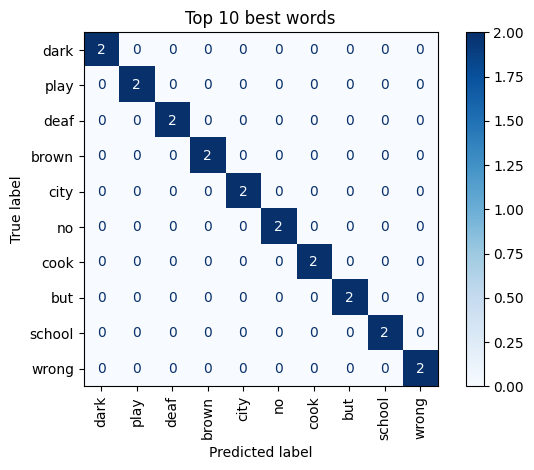

In [ ]:
# Danh sách tên lớp
class_names = list(label_map.keys())

# Tính toán top/bottom và confusion matrix
top10_idx, bottom5_idx, cm = get_top_bottom_classes(model, test_loader, class_names, device)

# Vẽ riêng
plot_confusion_subset(cm, top10_idx, class_names, title="Top 10 best words")


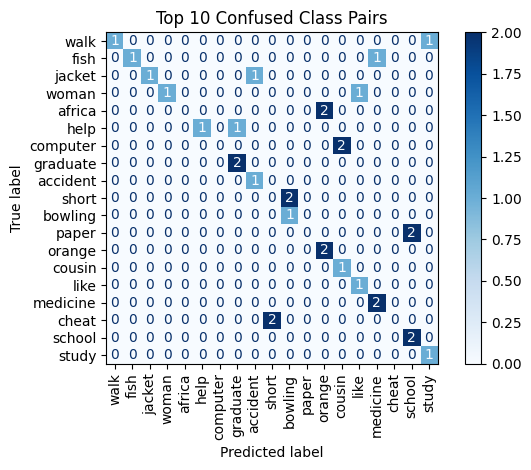

In [ ]:
def plot_top_confusion_pairs(cm, class_names, top_k=10):
    """
    Vẽ confusion matrix cho các cặp lớp bị nhầm nhiều nhất.
    """
    # Bước 1: Tìm các cặp bị nhầm (i ≠ j)
    confused_pairs = []
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if i != j and cm[i, j] > 0:
                confused_pairs.append(((i, j), cm[i, j]))

    # Bước 2: Sắp xếp giảm dần theo số lần nhầm
    confused_pairs.sort(key=lambda x: x[1], reverse=True)
    top_pairs = confused_pairs[:top_k]

    # Bước 3: Tập hợp các chỉ số lớp liên quan
    selected_indices = sorted(set(i for pair, _ in top_pairs for i in pair))

    # Bước 4: Vẽ tập con confusion matrix
    plot_confusion_subset(cm, selected_indices, class_names,
                          title=f"Top {top_k} Confused Class Pairs")

plot_top_confusion_pairs(cm, class_names, top_k=10)


# Test

In [ ]:
torch.save(model.state_dict(), "best_model.pth")


In [ ]:
# Load mô hình đã lưu
model.load_state_dict(torch.load("best_model.pth"))

<All keys matched successfully>

In [ ]:
from sklearn.metrics import top_k_accuracy_score, accuracy_score
import numpy as np

all_preds1 = []
all_labels1 = []
all_logits1 = []


with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)  # shape: [B, num_classes]
        logits = outputs.cpu().numpy()
        preds = outputs.argmax(dim=1).cpu().numpy()
        labels = y_batch.cpu().numpy()

        all_logits1.append(logits)               # ❗ sửa từ extend → append
        all_preds1.extend(preds)
        all_labels1.extend(labels)

# Convert to numpy
all_logits1 = np.vstack(all_logits1)             # ❗ kết hợp thành (num_samples, num_classes)
all_labels1 = np.array(all_labels1)
all_preds1 = np.array(all_preds1)

# Accuracy
top1_acc = accuracy_score(all_labels1, all_preds1)
top5_acc = top_k_accuracy_score(all_labels1, all_logits1, k=5)

print(f"✅ Top-1 Accuracy: {top1_acc * 100:.2f}%")
print(f"✅ Top-5 Accuracy: {top5_acc * 100:.2f}%")



✅ Top-1 Accuracy: 68.92%
✅ Top-5 Accuracy: 88.51%


In [ ]:
label_map = np.load("label_map.npy", allow_pickle=True).item()
reverse_label_map = {v: k for k, v in label_map.items()}  # ID → Từ

# Tạo danh sách label theo thứ tự index
labels = [reverse_label_map[i] for i in range(len(reverse_label_map))]


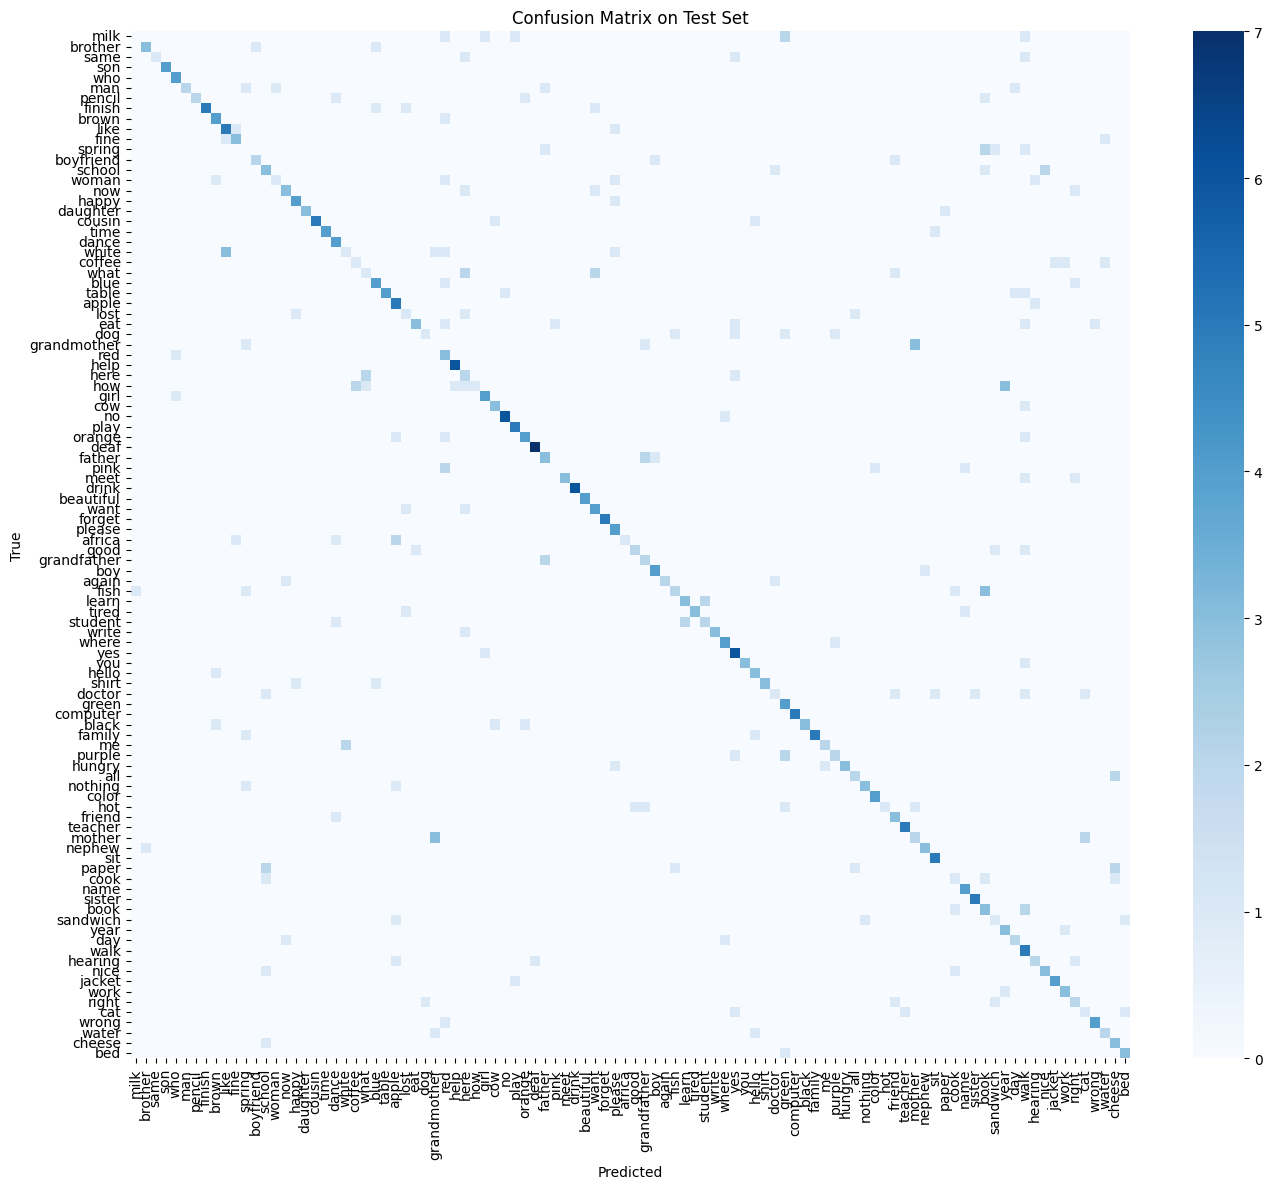

In [ ]:
cm = confusion_matrix(all_labels1, all_preds1)
plt.figure(figsize=(14, 12))
sns.heatmap(cm, cmap="Blues", annot=False, fmt='d',
            xticklabels=labels, yticklabels=labels)

plt.title("Confusion Matrix on Test Set")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
def top1_acc_per_timestep(outputs, targets):
    # outputs: (N, C, T), targets: (N,)
    preds = outputs.argmax(dim=1)  # (N, T)
    correct = preds.eq(targets.unsqueeze(1))  # so với label thật (N, T)
    acc_per_t = correct.float().mean(dim=0)  # accuracy tại mỗi timestep
    return acc_per_t  # shape: (T,)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = STGCN(in_channels=1629, num_classes=100)
model.load_state_dict(torch.load("/content/best_model.pth", map_location=device))
model.to(device)
model.eval()


STGCN(
  (data_bn): BatchNorm1d(1629, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): STGCNBlock(
    (gcn): Conv1d(1629, 24, kernel_size=(1,), stride=(1,))
    (tcn_branches): ModuleList(
      (0): Conv1d(24, 24, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): Conv1d(24, 24, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
      (2): Conv1d(24, 24, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
    )
    (bn): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (attn): TemporalAttention(
      (attn): Sequential(
        (0): AdaptiveAvgPool1d(output_size=1)
        (1): Conv1d(24, 24, kernel_size=(1,), stride=(1,))
        (2): Sigmoid()
      )
    )
    (se): ChannelSE(
      (se): Sequential(
        (0): AdaptiveAvgPool1d(output_size=1)
        (1): Conv1d(24, 1, kernel_size=(1,), stride=(1,))
        (2): ReLU()
        (3): Conv1d(1, 24, kern

In [ ]:
import numpy as np
X_test = torch.tensor(np.load("X_test.npy"), dtype=torch.float32).to(device)
y_test = torch.tensor(np.load("y_test.npy"), dtype=torch.long).to(device)
y_test = torch.argmax(y_test, dim=1)


In [ ]:
from sklearn.metrics import accuracy_score, top_k_accuracy_score

with torch.no_grad():
    if X_test.shape[1] == 50:
        X_test = X_test.permute(0, 2, 1)  # [N, T, C] → [N, C, T]
    outputs = model(X_test)
    logits = outputs.cpu().numpy()
    preds = torch.argmax(outputs, dim=1).cpu().numpy()
    labels = y_test.cpu().numpy()


top1 = accuracy_score(labels, preds)
top5 = top_k_accuracy_score(labels, logits, k=5)

print(f"Top-1 Accuracy: {top1*100:.2f}%")
print(f"Top-5 Accuracy: {top5*100:.2f}%")




Top-1 Accuracy: 68.92%
Top-5 Accuracy: 88.51%


# **Video nhận dạng**